# Instala Biblioteca PySDDP

In [5]:
!pip install PySDDP=='0.0.34'

# Faz o link com a sua conta do Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Realiza os Imports Necessários



*   Classe Newave do PySDDP: Realiza a leitura do deck do modelo Newave e encapsula todas as informações em um único objeto
*   Importa a biblioteca Numpy com o "apelido" np
* Importa as classes gráficas matplotlib e plotly



In [7]:
from PySDDP.Pen import Newave
import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from random import randint

# Realiza a leitura de um deck do pmo

Adaptar a variável caminho conforme a pasta em que o deck estiver no seu Google Drive

In [8]:
Caminho = '/content/drive/MyDrive/NewaveJan2021'

Caso = Newave(Caminho)

OK! Leitura do CASO.DAT realizada com sucesso.
OK! Leitura do ARQUIVOS.DAT realizada com sucesso.
OK! Leitura do DGER.DAT realizada com sucesso.
OK! Leitura do HIDR.DAT realizada com sucesso.
OK! Leitura do VAZOES.DAT realizada com sucesso.
OK! Leitura do MODIF.DAT realizada com sucesso. ( 114 Usinas Hidraulicas Modificadas )
OK! Leitura do EXPH.DAT realizada com sucesso. ( 0 Usinas Hidraulicas Expandidas )
OK! Leitura do CONFHD.DAT realizada com sucesso.
OK! Leitura do REE.DAT realizada com sucesso. ( 12 Reservatórios Equivalentes de Energia Foram Lidos )
OK! Leitura do SISTEMA.DAT realizada com sucesso.


# Captura uma UHE

Armazena todas as informações de uma Usina Hidrelétrica (UHE) do deck em um dicionário de dados chamado uhe.

Como o foco do programa será a análise de uma série temporal de vazões, armazena o array contendo as vazões da UHE na variável "vazões".

In [9]:
uhe = Caso.confhd.get('itaipu')

vazoes = uhe['vazoes']

print(vazoes)

[[16387 21639 22979 ...  6669  6784 10683]
 [14288 16700 13753 ...  7644  7130 13757]
 [16743 14271 10964 ...  4660  4133  8014]
 ...
 [10463  9634 15982 ...  4426  5236 11206]
 [10912 15455 14634 ...  3883  4952  7392]
 [12803     0     0 ...     0     0     0]]


# Plota todas a séries anuais históricas de vazão da UHE

Em vermelho, média histórica mensal ou MLT (Média de Longo Termo)

Em vermelho pontilhado, média mensal + ou - o desvio padrão mensal.

Em azul, o ano corrente. Como este caso é referente a janeiro de 2021 (somente o mês de janeiro de 2021 possui informação).

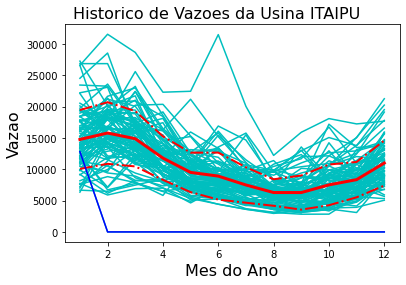

In [10]:
Caso.confhd.plot_vaz(uhe)

# Plota Gráfico de Vazões (Janeiro x Dezembro)

In [11]:
nanos = len(vazoes)
nmes = len(vazoes[0])

janeiros = np.zeros(nanos-2)
dezembros = np.zeros(nanos-2)

for i in range(nanos-2):
  janeiros[i] = vazoes[i+1,0]
  dezembros[i] = vazoes[i,11]

fig = go.Figure()
fig.add_trace(go.Scatter(x=dezembros, y=janeiros, mode='markers'))
fig.update_layout(title='UHE '+uhe['nome'],
                  xaxis_title='Vazão Natural Dezembro (m^3/s)',
                  yaxis_title='Vazão Natural Janeiro (mˆ3/s)')
fig.show()

# Calcula Médias e Desvios Padrões Mensais

In [12]:
nanos = len(vazoes)   # Total de anos menos o primeiro e último

media = np.mean(vazoes[1:(nanos-1)], axis=0)    
desvio = np.std(vazoes[1:(nanos-1)], axis=0)    

print(media)
print(desvio)


[14754.05617978 15887.60674157 14941.95505618 11857.13483146
  9562.04494382  8982.70786517  7565.39325843  6355.13483146
  6340.15730337  7598.2247191   8452.57303371 11116.5505618 ]
[4741.25932249 4636.02998172 4090.26180286 3242.76391402 3001.16458635
 3663.58465153 2745.11733491 2030.41713869 2668.32698036 3184.24243104
 2703.98561797 3441.65074063]


# Calcula Função de Auto-Correlação

In [13]:
ord_max = 11

# Calcula funcao de auto-correlacao (uma para cada mes)
fac = np.zeros( (12, ord_max+1), 'd')
for ilag in range(ord_max+1):
    for imes in range(12):
        for iano in np.arange(1,nanos-1):
              ano_ant = iano
              mes_ant = imes - ilag
              if mes_ant < 0:
                  ano_ant -= 1
                  mes_ant += 12
              fac[imes][ilag] += (vazoes[iano][imes] - media[imes]) * (vazoes[ano_ant][mes_ant] - media[mes_ant])
        fac[imes][ilag] /= (nanos-2)
        fac[imes][ilag] /= (desvio[imes]*desvio[mes_ant])
print(fac)

[[1.         0.69848673 0.53371652 0.45156359 0.42453876 0.45384466
  0.44320088 0.25551829 0.34048947 0.39391642 0.27981861 0.28944487]
 [1.         0.66678933 0.53397051 0.39699529 0.26948064 0.27733161
  0.36215345 0.33760863 0.16735455 0.28132639 0.28238953 0.20724979]
 [1.         0.67431424 0.45296337 0.42453491 0.34022912 0.22332257
  0.09105349 0.19730053 0.31967241 0.11615324 0.21317209 0.26644551]
 [1.         0.77744871 0.62724212 0.42504915 0.50520733 0.46869218
  0.40866372 0.32861822 0.4701213  0.48385335 0.35547088 0.34359241]
 [1.         0.69671183 0.56226243 0.54949759 0.37928292 0.49354214
  0.41856214 0.3595636  0.32415905 0.49412653 0.49554475 0.34175656]
 [1.         0.77962167 0.57280688 0.43814277 0.46128436 0.38797001
  0.49221992 0.42306032 0.32790438 0.25621317 0.44337088 0.53462186]
 [1.         0.81405684 0.67917231 0.64944518 0.49958774 0.51038545
  0.40363684 0.47094761 0.36513322 0.30493044 0.25395084 0.44954676]
 [1.         0.74573218 0.65584791 0.6628

# Calcula Função de Auto-Correlação Parcial (FACP)

In [14]:
# Calcula funcao de auto-correlacao parcial (uma para cada mes)
facp = np.zeros((12, ord_max+1), 'd')
for ilag in np.arange(1,ord_max+1):
    for imes in range(12):
        A = np.eye(ilag)
        B = np.zeros(ilag)
        # Preenche matriz triangular superior
        for ilin in range(len(A)):
            for icol in range( len(A) ):           # TODO: Aqui poderia ser np.arange(ilin+1,len(A)): Testar depois
                if icol > ilin:
                    mes = imes - ilin - 1
                    if mes < 0:
                        mes = mes + 12
                    A[ilin][icol] = fac[mes][icol-ilin]
            B[ilin] = fac[imes][ilin+1]
        # Preenche matriz triangular inferior
        for ilin in range(len(A)):
            for icol in range( len(A) ):          # TODO: Aqui poderia ser np.arange(0, ilin): Testar depois
                if icol < ilin:
                    A[ilin][icol] = A[icol][ilin]
        phi = np.linalg.solve(A,B)
        facp[imes][ilag] = phi[ len(phi)-1 ]
print(facp)

[[ 0.          0.69848673  0.02356743  0.04009366  0.06429324  0.21191113
   0.02057326 -0.24401332  0.20727583  0.11113805  0.12620704 -0.15189457]
 [ 0.          0.66678933  0.13322563 -0.02062933 -0.15275392  0.01251916
   0.21816459 -0.01553456 -0.16162131  0.17111595 -0.01448479  0.03635542]
 [ 0.          0.67431424  0.00600986  0.12390041  0.05679978 -0.0333488
  -0.27513693  0.03712757  0.24906171 -0.23353007  0.14289013  0.06198223]
 [ 0.          0.77744871  0.18888196  0.00835643  0.25274062  0.17951583
   0.19823585  0.1534733   0.32499379  0.02029495  0.13308371 -0.17802201]
 [ 0.          0.69671183  0.05208821  0.19820829  0.01603464  0.20757988
   0.00644419  0.03893382  0.05152394  0.3725042   0.11728534 -0.12375951]
 [ 0.          0.77962167  0.05758971 -0.05680162  0.05855651  0.12723275
   0.10615451  0.03442316 -0.08897007 -0.12386612  0.17146731  0.26103696]
 [ 0.          0.81405684  0.11350608  0.30204843  0.00344998  0.07992193
   0.01217169 -0.01356087 -0.1118

# Identifica a Ordem P de cada mês

Utiliza os limites de significância na FACP.

In [15]:
# Identificacao da ordem
IC = 1.96/np.sqrt(nanos-1)
ordem = np.zeros(12, 'i')
for imes in range(12):
    ordem[imes] = 0
    for ilag in range(ord_max+1):
        if facp[imes][ilag] > IC or facp[imes][ilag] < -IC:
            ordem[imes] = ilag

# Calcula os coeficientes $\phi$ para cada mês

In [16]:
# Calculo dos coeficientes
coef_parp = np.zeros( (12,ord_max), 'd')
for imes in range(12):
    ilag = ordem[imes]
    A = np.eye(ilag)
    B = np.zeros(ilag)
    # Preenche matriz triangular superior
    for ilin in range(len(A)):
        for icol in range( len(A) ):             # TODO: Aqui poderia ser np.arange(ilin+1,len(A)): Testar depois
            if icol > ilin:
                mes = imes - ilin - 1
                if mes < 0:
                   mes = mes + 12
                A[ilin][icol] = fac[mes][icol-ilin]
        B[ilin] = fac[imes][ilin+1]
    # Preenche matriz triangular inferior
    for ilin in range(len(A)):
        for icol in range( len(A) ):             # TODO: Aqui poderia ser np.arange(0, ilin): Testar depois
            if icol < ilin:
                A[ilin][icol] = A[icol][ilin]
    phi = np.linalg.solve(A,B)
    for iord in range ( len(phi) ):
        coef_parp[imes][iord ] = phi[ iord ]


# Traça FAC e FACP

Colocar na variável mes, o mêês desejado.

0 - Jan, 1 - Fev, ..., 11 Dezembro

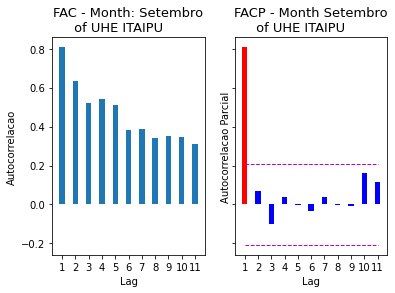

In [17]:
# Escolhe mês para traçar a FAC e FACP (0-Janeiro, ..., 11-Dezembro)
mes = 8

ordmax = ord_max

vazoes = uhe['vazoes']

nanos = len(vazoes) - 1

if mes == 0:
    str_mes = 'January'
elif mes == 1:
    str_mes = 'Fevereiro'
elif mes == 2:
    str_mes = 'Marco'
elif mes == 3:
    str_mes = 'Abril'
elif mes == 4:
    str_mes = 'Maio'
elif mes == 5:
    str_mes = 'Junho'
elif mes == 6:
    str_mes = 'Julho'
elif mes == 7:
    str_mes = 'Agosto'
elif mes == 8:
    str_mes = 'Setembro'
elif mes == 9:
    str_mes = 'Outubro'
elif mes == 10:
    str_mes = 'Novembro'
else:
    str_mes = 'Dezembro'

IC = 1.96/np.sqrt(nanos-1)

cores = []
limitesup = []
limiteinf = []
for elemento in facp[mes][1:ordmax+1]:
    limitesup.append(IC)
    limiteinf.append(-IC)
    if elemento > IC or elemento < -IC:
        cores.append('r')
    else:
        cores.append('b')

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
barWidth = 0.40

titulo = 'FAC e FACP of ' + str_mes + ' - UHE ' + uhe['nome']
f.canvas.set_window_title(titulo)

ax1.bar(np.arange(1,ordmax+1), fac[mes][1:ordmax+1], barWidth, align='center')
ax2.bar(np.arange(1,ordmax+1), facp[mes][1:ordmax+1], barWidth, align='center', color = cores)
ax2.plot(np.arange(1,ordmax+1), limitesup, 'm--', lw=1)
ax2.plot(np.arange(1,ordmax+1), limiteinf, 'm--', lw=1)

ax1.set_xticks(np.arange(1,ordmax+1))
ax2.set_xticks(np.arange(1,ordmax+1))
tituloFAC =  'FAC - Month: ' + str_mes + '\n of UHE ' + uhe['nome']
tituloFACP = 'FACP - Month ' + str_mes +  '\n of UHE ' + uhe['nome']
ax1.set_title(tituloFAC,  fontsize = 13)
ax2.set_title(tituloFACP, fontsize =13)
ax1.set_xlabel('Lag')
ax2.set_xlabel('Lag')
ax1.set_ylabel('Autocorrelacao')
ax2.set_ylabel('Autocorrelacao Parcial')

plt.show()

# Função parp do PySDDP

In [18]:
Caso.confhd.parp(uhe,11)

(array([ 7,  6,  9,  8,  9, 11,  3,  3,  1,  6,  9,  9], dtype=int32),
 array([[ 0.62728369,  0.00530905, -0.02743016, -0.09505849,  0.24058907,
          0.20167674, -0.24401332,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.54888243,  0.18342386,  0.05597884, -0.18373373, -0.13222451,
          0.21816459,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.63111041, -0.08658362,  0.09969999,  0.05134657,  0.12387371,
         -0.31770113, -0.05968108,  0.42279339, -0.23353007,  0.        ,
          0.        ],
        [ 0.64738419,  0.13756453, -0.19887268,  0.11826617,  0.01452961,
          0.06228196, -0.06366691,  0.32499379,  0.        ,  0.        ,
          0.        ],
        [ 0.39015088,  0.07850496,  0.169567  , -0.16599308,  0.25168454,
         -0.05099215, -0.02443842, -0.17852109,  0.3725042 ,  0.        ,
          0.        ],
        [ 0.65202414,  0.07137212, -0.14370675,  0.02363444,  0.04244655,


# Função plota_parp do PySDDP

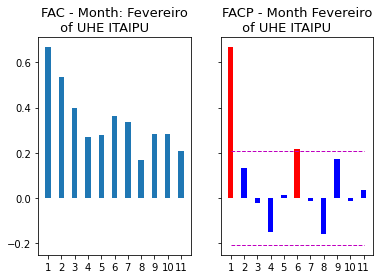

In [19]:
Caso.confhd.plota_parp(uhe, 1, 11)

# Cálculo dos Resíduos Normalizados

In [20]:
residuos = np.zeros( (nanos-1, 12) )
for iano in np.arange(1,nanos-1):
    for imes in range(12):
        residuos[iano][imes]= ( vazoes[iano][imes]-media[imes] ) / desvio[imes]
        for ilag in range(ord_max):
            ano_ant = iano
            mes_ant = imes - ilag - 1
            if mes_ant < 0:
                ano_ant -= 1
                mes_ant += 12
            residuos[iano][imes] -= coef_parp[imes][ilag]*(vazoes[ano_ant][mes_ant]-media[mes_ant])/desvio[mes_ant]
print(residuos)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.04713242  0.30573399 -0.19731359 ...  0.36420739 -0.50921698
   1.16468393]
 [ 0.04752937 -0.67765432 -0.8636207  ... -0.12131538 -0.90792895
   0.1793556 ]
 ...
 [-0.46033225 -0.16264614 -0.31916977 ...  0.15593065  1.64605568
   0.09595906]
 [ 1.06171995 -1.32124276  0.46244073 ...  0.87537958  0.9635674
  -0.62236832]
 [-0.86864783 -0.73885365  0.9865084  ... -0.69285986 -0.18791402
   1.00290701]]


# Plota Nuvem de Cenários Sintéticos

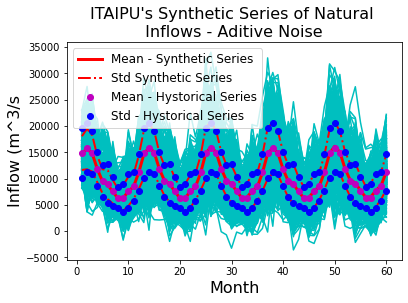

In [21]:
nr_cen = 1000

#
# Pega Parâmetros Básicos
#
nanos_estudo = len(uhe['status_vol_morto'])
nmeses_estudo = len(uhe['status_vol_morto'][0])
nestagios = nanos_estudo*nmeses_estudo
vazoes = uhe['vazoes']
nanos = len(vazoes) - 1
media = np.mean(vazoes[1:(nanos-1)], 0)    # A primeira serie historica eh utilizada como tendencia (despreze-a)
desvio = np.std(vazoes[1:(nanos-1)], 0)    # A primeira serie historica eh utilizada como tendencia (despreze-a)

# Gera series sinteticas
sintetica_adit = np.zeros((nr_cen,nestagios),'d')
for iser in range(nr_cen):
    contador = -1
    for iano in range(nanos_estudo):
        for imes in range(nmeses_estudo):
            contador += 1
            serie = randint(1,nanos-2)
            valor = media[imes] + desvio[imes]*residuos[serie][imes]
            for ilag in range(ord_max):
                mes_ant = imes - ilag - 1
                ano_ant = iano
                if mes_ant < 0:
                    mes_ant += 12
                    ano_ant -= 1
                if ano_ant < 0:
                    vazant = media[mes_ant]
                else:
                    vazant = sintetica_adit[iser][contador-1-ilag]
                valor += desvio[imes]*coef_parp[imes][ilag]*(vazant-media[mes_ant])/desvio[mes_ant]
            sintetica_adit[iser][contador] = valor

x_axis = np.arange(1, nestagios+1)
plt.plot(x_axis, sintetica_adit.transpose(), 'c-')
plt.plot(x_axis, np.mean(sintetica_adit,0), 'r-', lw=3, label='Mean - Synthetic Series')
plt.plot(x_axis, np.mean(sintetica_adit,0) + np.nanstd(sintetica_adit, axis=0), 'r-.', lw=2, label='Std Synthetic Series')
plt.plot(x_axis, np.mean(sintetica_adit,0) - np.nanstd(sintetica_adit, axis=0), 'r-.', lw=2)
m = np.concatenate([ media, media, media, media, media])
d = np.concatenate([ desvio, desvio, desvio, desvio, desvio])
plt.plot(x_axis, m, 'mo', lw=3, label='Mean - Hystorical Series')
plt.plot(x_axis, m + d, 'bo', lw=2, label='Std - Hystorical Series')
plt.plot(x_axis, m - d, 'bo', lw=2)
titulo = uhe['nome'].strip() + "'s Synthetic Series of Natural \n" " Inflows - Aditive Noise "
plt.title(titulo, fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Inflow (m^3/s', fontsize=16)
plt.legend(fontsize=12)
plt.show()


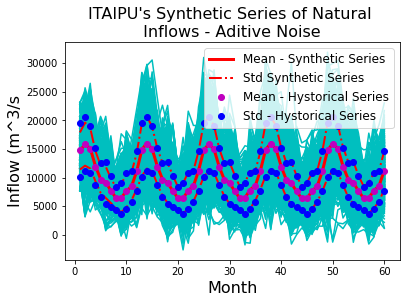

In [22]:
sinteticos = Caso.confhd.gera_cen_sinteticos(uhe, 11, 1000)

In [25]:
print(np.shape(sinteticos))

(1000, 60)
